## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE

import shap


## Load Dataset

In [2]:
df = pd.read_csv("stroke.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Inspection of Data

In [3]:
print(df.info())
print(df.isnull().sum())
print(df['stroke'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
wo

## Data Cleaning and Preproccesing

In [4]:
df = df.drop("id", axis=1)
df["bmi"].fillna(df["bmi"].median(), inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_13780\307852817.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(df["bmi"].median(), inplace=True)


In [5]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

cat_cols = ['gender', 'ever_married', 'work_type',
            'Residence_type', 'smoking_status']
num_cols = ['age', 'avg_glucose_level', 'bmi']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

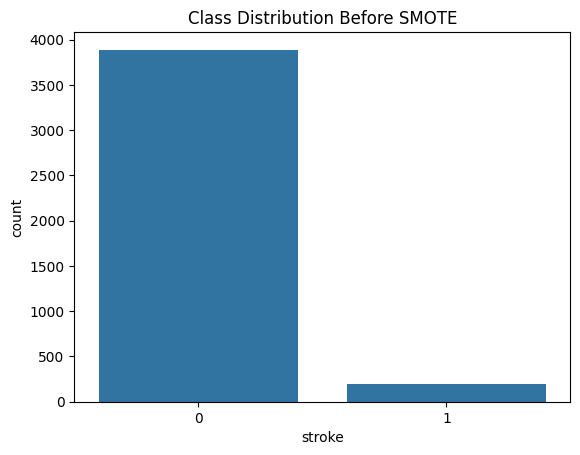

In [7]:
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()

## Feature Encoding & Scaling

In [8]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(X_train[cat_cols])

X_train_cat = pd.DataFrame(
    ohe.transform(X_train[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_train.index
)

X_test_cat = pd.DataFrame(
    ohe.transform(X_test[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_test.index
)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

X_train_num = pd.DataFrame(
    scaler.transform(X_train[num_cols]),
    columns=num_cols, index=X_train.index
)

X_test_num = pd.DataFrame(
    scaler.transform(X_test[num_cols]),
    columns=num_cols, index=X_test.index
)

## Train-Test Split & Class Imbalance Handling

In [10]:
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final  = pd.concat([X_test_num,  X_test_cat],  axis=1)

In [11]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_final, y_train)

In [12]:
print(df['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


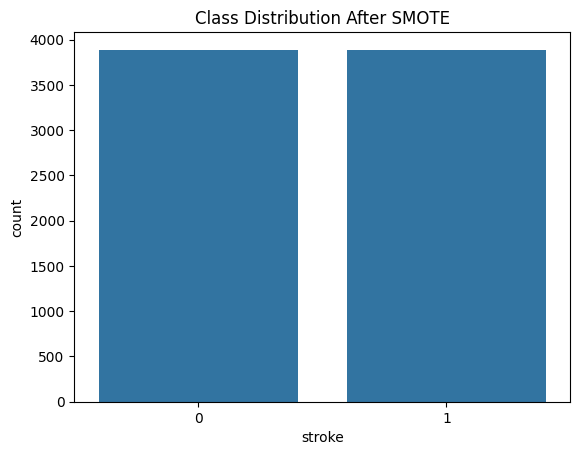

In [13]:
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()

## Model Training 

In [14]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=42),
    "Naive Bayes": GaussianNB()
}

for model in models.values():
    model.fit(X_train_res, y_train_res)

## Model Evaluation & Metrics


Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.78      0.23        50

    accuracy                           0.75      1022
   macro avg       0.56      0.76      0.54      1022
weighted avg       0.94      0.75      0.82      1022



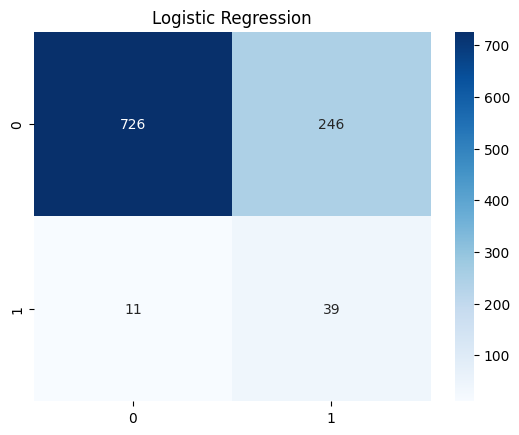


SVM
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.11      0.48      0.18        50

    accuracy                           0.78      1022
   macro avg       0.54      0.64      0.53      1022
weighted avg       0.93      0.78      0.84      1022



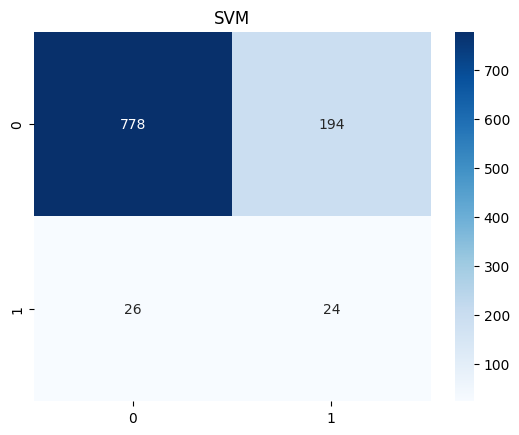


Random Forest
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       972
           1       0.09      0.10      0.09        50

    accuracy                           0.91      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.91      0.91      0.91      1022



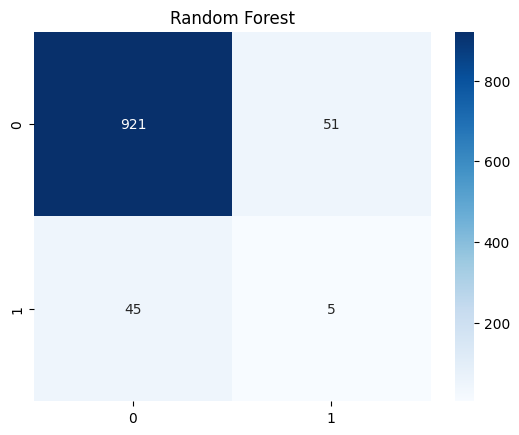


Naive Bayes
              precision    recall  f1-score   support

           0       1.00      0.28      0.43       972
           1       0.07      0.98      0.12        50

    accuracy                           0.31      1022
   macro avg       0.53      0.63      0.28      1022
weighted avg       0.95      0.31      0.42      1022



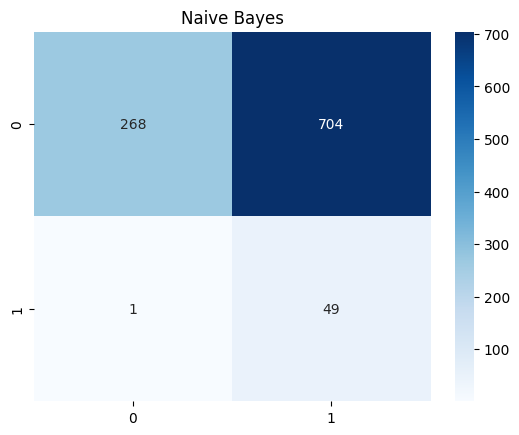

,Model,Accuracy,ROC AUC
0,Logistic Regression,0.748532,0.844239
1,SVM,0.784736,0.775412
2,Random Forest,0.906067,0.769064
3,Naive Bayes,0.310176,0.780885


In [15]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:,1]

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.show()

    results.append([
        name,
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ])

results_df = pd.DataFrame(
    results, columns=["Model", "Accuracy", "ROC AUC"]
)
results_df

## Model Evaluation & Metrics

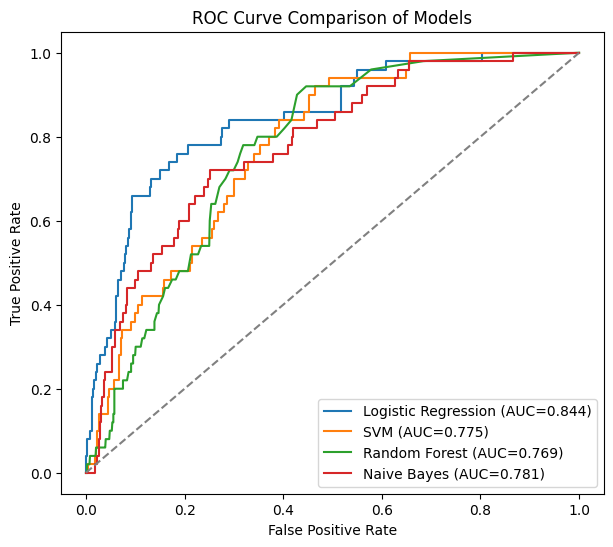

In [16]:
plt.figure(figsize=(7,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test_final)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend()
plt.show()

In [17]:
best_model = models["Random Forest"]


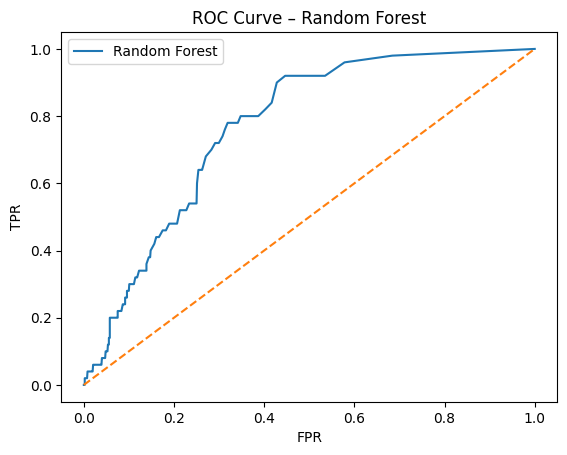

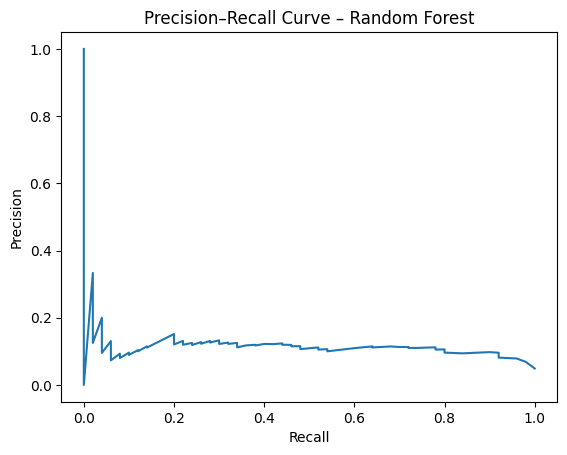

In [18]:
y_prob_rf = best_model.predict_proba(X_test_final)[:,1]

# ROC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()

# PR
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
plt.plot(recall_rf, precision_rf)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Random Forest")
plt.show()

## Probability Calibration

In [19]:
calibrated = CalibratedClassifierCV(best_model, method="isotonic", cv=5)
calibrated.fit(X_train_res, y_train_res)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(n_estimators=200,
                                                        random_state=42),
                       method='isotonic')

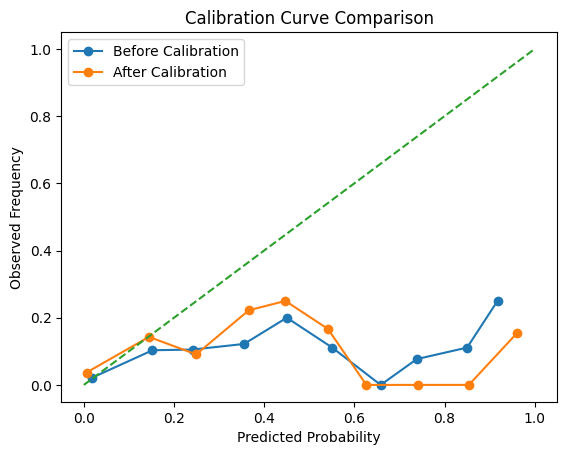

In [20]:
y_prob_uncal = best_model.predict_proba(X_test_final)[:,1]
y_prob_cal   = calibrated.predict_proba(X_test_final)[:,1]

pt_u, pp_u = calibration_curve(y_test, y_prob_uncal, n_bins=10)
pt_c, pp_c = calibration_curve(y_test, y_prob_cal, n_bins=10)

plt.plot(pp_u, pt_u, marker='o', label="Before Calibration")
plt.plot(pp_c, pt_c, marker='o', label="After Calibration")
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.show()

## Risk Triage System

In [21]:
def stroke_triage(model, X):
    prob = model.predict_proba(X)[0][1]
    
    if prob < 0.20:
        risk = "LOW RISK"
    elif prob < 0.50:
        risk = "MEDIUM RISK"
    else:
        risk = "HIGH RISK"
        
    return prob, risk

stroke_triage(calibrated, X_test_final.iloc[[0]])

(np.float64(0.0011904761904761904), 'LOW RISK')

## SHAP Explainability


1. Visualizing Global Feature Importance...


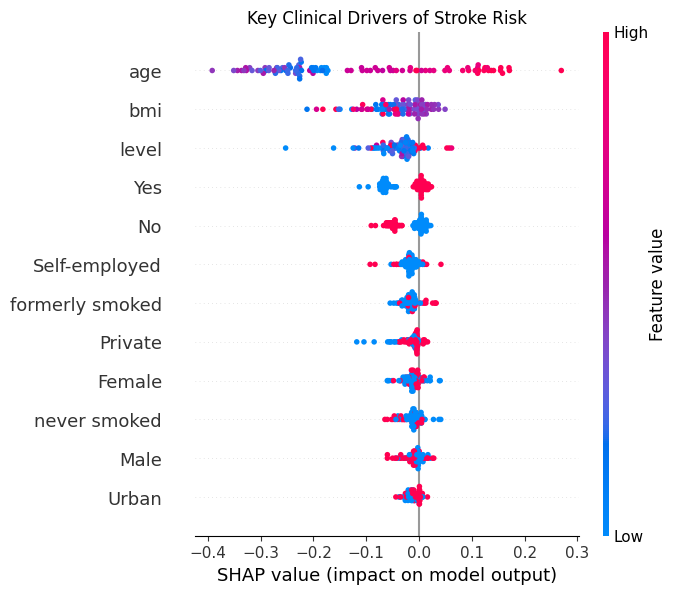

RESULTS: 
PATIENT 3725 TRIAGE: LOW RISK
Calculated Probability: 0.0012

2. Waterfall Explanation (Step-by-Step Risk):


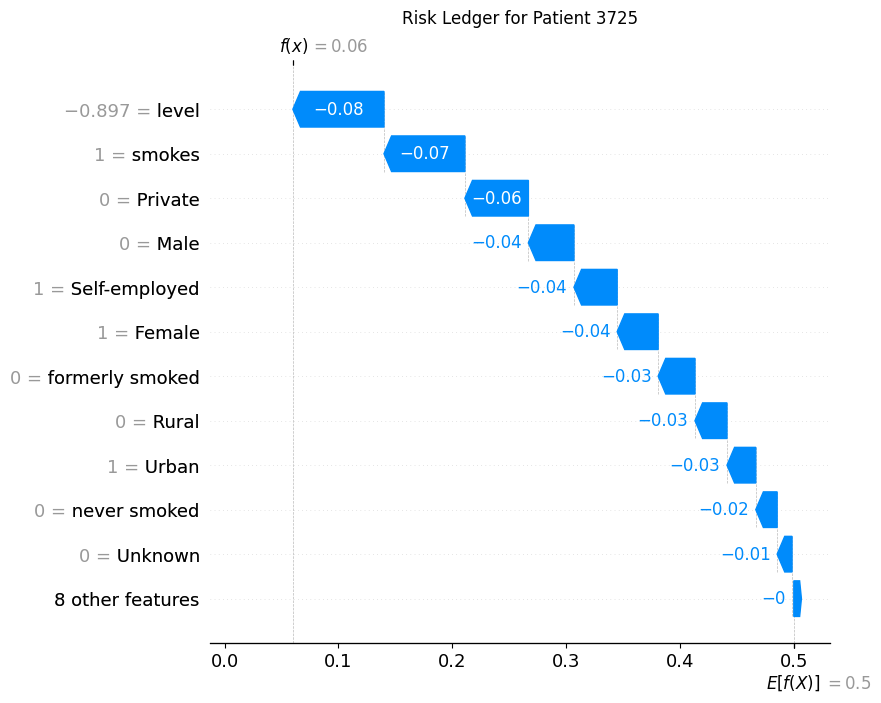


3. Force Plot:


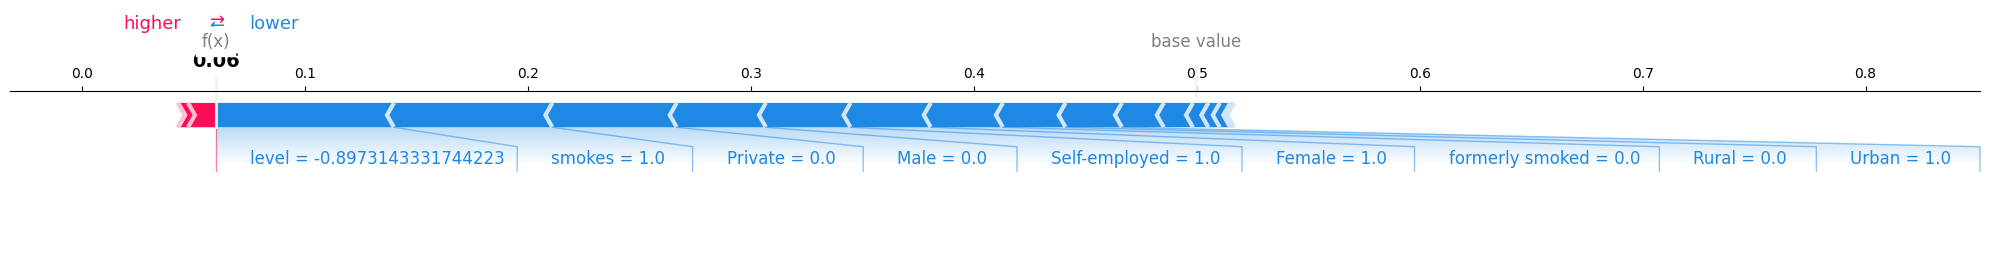

In [22]:
# 1. Clean Feature Names for Plotting
# Removes prefixes (e.g., 'work_type_') to prevent overlap and make labels clinical
clean_columns = [col.split('_')[-1] if '_' in col else col for col in X_test_final.columns]
X_test_clean = X_test_final.copy()
X_test_clean.columns = clean_columns

# 2. Compute SHAP
explainer = shap.TreeExplainer(best_model)
X_test_subset = X_test_clean.sample(100, random_state=42)
raw_shap_values = explainer.shap_values(X_test_subset)

# Handle SHAP output format for Class 1 (Stroke)
if isinstance(raw_shap_values, list):
    shap_to_plot = raw_shap_values[1]
else:
    # Handle different SHAP version output shapes
    shap_to_plot = raw_shap_values[:, :, 1] if len(raw_shap_values.shape) == 3 else raw_shap_values

print("\n1. Visualizing Global Feature Importance...")
fig = plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_to_plot, 
    X_test_subset, 
    max_display=12, 
    show=False
)
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1)
plt.title("Key Clinical Drivers of Stroke Risk")
plt.show()

sample_idx = 0
# Calling your existing function to get consistent probability and risk labels
prob, risk = stroke_triage(calibrated, X_test_final.iloc[[sample_idx]])

print("RESULTS: ")
print(f"PATIENT {X_test_final.index[sample_idx]} TRIAGE: {risk}")
print(f"Calculated Probability: {prob:.4f}")

# WATERFALL PLOT (The Risk Ledger)
print("\n2. Waterfall Explanation (Step-by-Step Risk):")
exp = shap.Explanation(
    values=shap_to_plot[sample_idx], 
    base_values=explainer.expected_value[1], 
    data=X_test_subset.iloc[sample_idx].values, 
    feature_names=X_test_subset.columns.tolist()
)

plt.figure(figsize=(10, 6))
# This plot shows how we get from the 'base' risk to the final prediction
shap.plots.waterfall(exp, show=False, max_display=12)
plt.title(f"Risk Ledger for Patient {X_test_final.index[sample_idx]}", pad=30)
plt.show()

# LOCAL FORCE PLOT (Visual Fix: 20x3 Width)
print("\n3. Force Plot:")
shap.force_plot(
    explainer.expected_value[1], 
    shap_to_plot[sample_idx, :], 
    X_test_subset.iloc[sample_idx, :], 
    matplotlib=True,
    show=False,
    contribution_threshold=0.05
)
fig = plt.gcf()
fig.set_size_inches(20, 3)
plt.tight_layout()
plt.show()

## SHAP VALUE VERIFICATION
Prediction = Base Value + ∑SHAP values

In [23]:
# Select the same patient used in plots
idx = sample_idx

# Base value (expected model output for class 1)
base_value = explainer.expected_value[1]

# Sum of SHAP values for this patient
shap_sum = shap_to_plot[idx].sum()

# Model raw prediction (uncalibrated RF)
rf_pred = best_model.predict_proba(X_test_final.iloc[[idx]])[0][1]

print("\nSHAP VERIFICATION")
print(f"Base Value (Expected Model Output): {base_value:.4f}")
print(f"Sum of SHAP Values:               {shap_sum:.4f}")
print(f"Base + SHAP Sum:                  {base_value + shap_sum:.4f}")
print(f"Random Forest Prediction:         {rf_pred:.4f}")


SHAP VERIFICATION
Base Value (Expected Model Output): 0.4999
Sum of SHAP Values:               -0.4399
Base + SHAP Sum:                  0.0600
Random Forest Prediction:         0.0950


## INTERPRETABLE RULES FOR CLINICIANS
Clinician's Quick Guide
1. PRIMARY DRIVERS: The model relies most heavily on: bmi, avg_glucose_level, age.
2. TRIAGE LOGIC: Risk categories are LOW (<20%), MEDIUM (20-50%), HIGH (>50%).
3. CALIBRATION: Probabilities have been adjusted via Isotonic Regression to match real-world stroke frequency.

## ETHICAL CONSIDERATIONS 

Our medical triage system predicts stroke risk using machine learning. While it works well, using AI in healthcare raises important ethical questions that we must consider.

### Main Ethical Issues

**1. Safety First**
- This AI helps doctors make decisions, but **doctors make the final call**, not the AI
- Missing a high-risk patient (false negative) can be life-threatening
- A doctor must review all medium and high-risk cases

**2. Fairness for Everyone**
- Our training data might not represent all types of patients equally
- The model might work better for some groups (age, gender, race) than others
- We used SMOTE to create fake data - this might add bias
- **We must test**: Does it work equally well for all patient groups?

**3. Explaining Decisions**
- Doctors need to understand WHY the AI predicts high/low risk
- We use SHAP to show which factors matter most for each patient
- Makes the AI trustworthy and useful for doctors

**4. Privacy Protection**
- Patient health data is highly sensitive
- All data must be anonymous (no names/IDs)
- Need strong security to prevent data leaks

**5. Patient Rights**
- Patients should know AI is being used in their care
- Patients can choose human-only assessment if they want
- Everyone should have equal access to this technology